<a href="https://colab.research.google.com/github/guillermohenrion/Social-Network-Analytics/blob/master/An%C3%A1lisis_de_texto_y_redes_en_tweet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Análisis de tópicos y de redes en Twitter 

### Paso 1: Dar de alta app en twitter

[Twitter Apps](https://developer.twitter.com/en/apps)


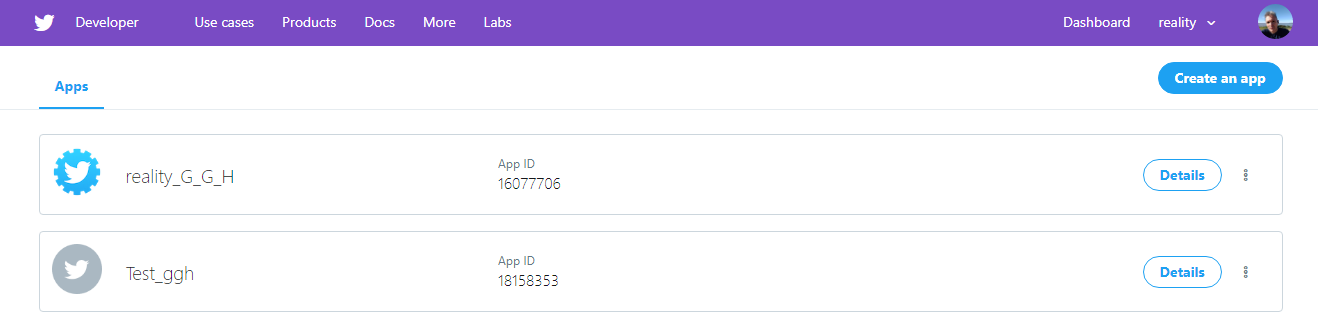

Nota: Poner una url de website válido

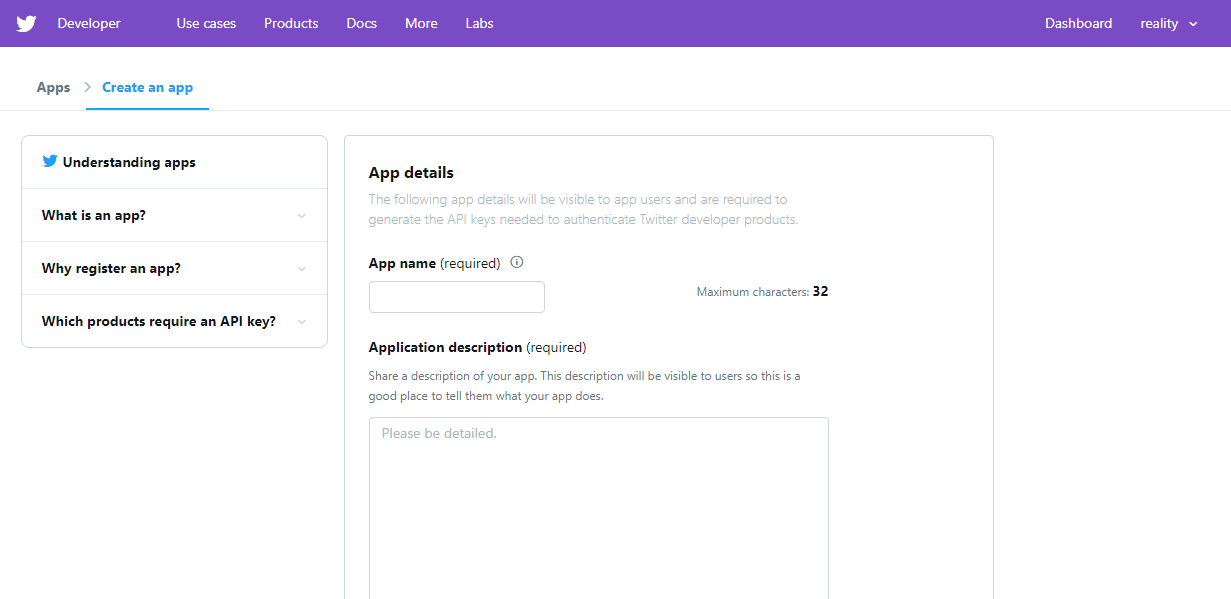

###Paso 2: Instalar las librerías y componentes, e importar librerías

Nota: Se necesita reiniciar en entorno de ejecución luego de la instalación 

In [1]:
!pip install twython
!pip install ftfy
!pip install pyLDAvis
!python -m spacy download es_core_news_sm
import nltk
nltk.download('stopwords')

✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
from twython import Twython
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os import path
import matplotlib.pyplot as plt
import os
import random
import pandas as pd
import ftfy
import re
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import gensim
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
import os
from gensim.models.wrappers import LdaMallet, ldamallet
from gensim.corpora import Dictionary
import spacy
import pyLDAvis.gensim
import csv
from unicodedata import normalize
import string
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 

###Paso 3: Conectar a la app Twitter

In [3]:
SEED = 8888

from spacy.lang.en.stop_words import STOP_WORDS

twitter = Twython("U63VxPMqLMwTPFUWEcPUeWMng", "sbz3lDj50wMdteqmDCXIexM7wuCxapGs89GtOlSDZV5C1W1hQz",
                    "280807268-MgZfUIUEb1vkPehfjB8sfuicMstiw0Afek49kkNL", "g8QammrsFv1zHfWrGtypSkNloEx1tmU2IpzRaW6JJNjIX")


#twitter2= Twython("1MBA20oxA5BiYqRaSjMN3oqYe","faLpEuitVadZAKZMYqtJwdMVrpLlZkLhtNOW94YsGsAfXwcadn",
#"280807268-mVB5Lz2MTRC7rUTNoIa3HF34LFyE6qGNQAkUPLVM","paviGM8YU6t0cTQlMUS8j1dysgcva1drWSA8J3tJJ2w2G")

twitter.sleep_on_rate_limit = True


###Paso 4: definir funciones varias (ej. preprocessing para convtertir texto a lista de palaras para construir el bow en donde cada docuemnto está representado como una lsita de palabras)

In [4]:
######################################################################################################################
# Funciones
######################################################################################################################

def sacarURL(t):
    p=re.compile('<a [^>]*>')
    p2=re.compile('</a>')
    r=re.sub(p, '', t)
    r=re.sub(p, '', t)
    r=re.sub(p, '', t)
    r=re.sub(p2, '', r)
    r=re.sub(p2, '', r)
    r=re.sub(p2, '', r)
    return r


def preprocessing(text,stopwords):
    text = text.lower()  # texto a minúsculas
    text = re.sub(r'\[.*?¿\]%', ' ', text)  # Se remueven corchetes
    text = re.sub(r'\(.*?¿\)%', ' ', text)  # Se remueven parentesis
    text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)  # Se remueven signos de puntuación
    text = re.sub(r'\w*\d\w*', '', text)  # Se remueven palabras que contienen dígitos.
    text = re.sub(r'\n', ' ', text)  # Sustituye nueva línea por un espacio
    text = re.sub(r'\s+', ' ', text, flags=re.I)  # Sustituye los múltiples espacios por sólo un espacio
    text = re.sub(r'[‘’“”…«»°*_/¿¡!?]', '', text)  # Remueve otros caracteres no sintácticos
    text = re.sub(r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+|\u20AC", r"\1",
                  normalize("NFD", text), 0, re.I)  # NFD y eliminar diacríticos y símbolo euro
    text = normalize('NFC', text)  # NFC
    bigram_list = bigram[text.split()]
    out_text = lemmatization(' '.join(bigram_list), allowed_postags=['NOUN'])  # ,'VERB','ADJ', 'PROPN'
    text_non_stop = [word for word in out_text if word not in stopwords]

    return text_non_stop

def lemmatization(texts, allowed_postags=None):
    if allowed_postags is None:
        allowed_postags = ['NOUN']
    texts_out = [token.lemma_ for token in nlp(texts) if token.pos_ in allowed_postags]
                 #allowed_postags and token.text not in black_list and len(token.text) > 2]
    return texts_out


def display_topics(model, model_type='lda'):
    for topic_idx, topic in enumerate(model.print_topics()):
        print('Topic %d:' % topic_idx)
        if model_type == 'hdp':
            print(" ".join(re.findall(r'\*(.[^\*-S]+).?', topic[1])), '\n')
        else:
            print(" ".join(re.findall(r'\"(.[^"]+).?', topic[1])), '\n')

def format_topics_sentences(ldamodel=0, corpus=[], texts=0):
    sent_topics_df = pd.DataFrame()  # - n

    # Tema principal en cada documento
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Tema dominante, porcentaje de contribución y palabras claves
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # Tema dominante
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(
                    pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Agrega el texto original al final
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df


###Paso 5: Traer tweets a analizar 

In [5]:
user_tweets = twitter.get_user_timeline(screen_name='alferdez',
                                        include_rts=True, count=200, tweet_mode="extended")
tweetdf=pd.DataFrame([], columns=['id', 'text'])

for tweet in user_tweets:
    tweet['text'] = Twython.html_for_tweet(tweet)
    new_row={'id':tweet['id'], 'text':sacarURL(tweet['text'])}
    tweetdf=tweetdf.append(new_row, ignore_index=True)
tweetdf

,id,text
0,1274897932840570882,📣DIÁLOGO VIRTUAL PARA PENSAR AMÉRICA LATINA DE...
1,1274896818686644224,Nota de @laura_vales a @Emilio_Persico 👇👇👇 ...
2,1274885759506567176,Con @alferdez analizamos la situación de Vicen...
3,1274762482821799936,"<span class=""twython-tweet-prefix"">@Estefy_may..."
4,1274503490556047361,Cuando me preguntan cómo estoy y si pienso afl...
...,...,...
195,1264613536208166915,"""¿Es angustiante salvarte? Angustiante es enfe..."
196,1264399178798637056,"""La pandemia deja al descbierto las almas"". @a..."
197,1264398825164242944,"""En los años que hablaba @Kicillofok Ni minist..."
198,1264398729563561984,"🗣 @alferdez: ""Acá no ha pasado como en otros l..."


###Paso 6: definir funciones varias (ej. preprocessing para convtertir texto a lista de palaras para construir el bow en donde cada docuemnto está representado como una lsita de palabras)

Representación vectorial de documentos en espacio de palabras

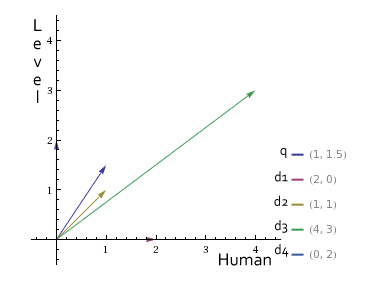

Preprocesamiento

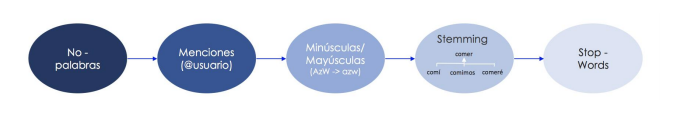

###Paso 7: Definir stopwords en español, nlp en español también (nlp permite lemmatizacion, part of speech tag, etc.) y bigramas

In [ ]:
# Palabra a ignorar junto a los stop words

black_list = ['span', 'twitter_com', 'suffix_twitter', 'n', 'q', 'eh', 'me', 'xq', 'z', 'x', 'etc', 'd', 'm', 's', 'u', 'p', 'l', 'as', 'av', 'j', 'porq', 'c',
              'v', 'cdo', 'i', 'unas', 'k', 't', 'pq', 'b', 'g', 'ne', 'r', 'h', 'qu', 'f', 'co', 'ud', 'sta', 'srta',
              'sr', 'sra', 'srita', 'tb', 'osea', 'po', 'ala', 'ami', 'ka', 'mo', 'migo', 'lis', 'in', 'idas', 'asique',
              'aunq', 'miy', 'lla', 'unlam', 'na', 'don', 'xxxx', 'yla', 'qie', 'qur', 'qye', 'fu', 'my', 'ke', 'laa',
              'll', 'mm', 'tmb', 'pr', 'ay', 'or', 'nc', 'xk', 'xx', 'ye', 'rn', 'hr', 'eramos', 'estabamos', 'estais',
              'estan', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos',
              'estarian', 'estarias', 'esteis', 'esten', 'estes', 'estuvieramos', 'estuviesemos', 'fueramos',
              'fuesemos', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras',
              'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hayais', 'hubieramos',
              'hubiesemos', 'mas', 'mia', 'mias', 'mio', 'mios', 'seais', 'sera', 'seran', 'seras', 'sere', 'sereis',
              'seria', 'seriais', 'seriamos', 'serian', 'serias', 'si', 'tambien', 'tendra', 'tendran', 'tendras',
              'tendre', 'tendreis', 'tendria', 'tendriais', 'tendriamos', 'tendrian', 'tendrias', 'teneis', 'tengais',
              'tenia', 'teniais', 'teniamos', 'tenian', 'tenias', 'tuvieramos', 'tuviesemos', 'vez']

In [7]:
stopwords = nltk.corpus.stopwords.words('spanish')
stopwords.extend(black_list )


In [31]:
# Nlp en idioma español

nlp = spacy.load('es_core_news_sm')

In [37]:
text='Esta es una sentencia con el fin de probar nlp. Otros fines no se propone.'
print([token.lemma_ for token in nlp(text)])
print([token.pos_ for token in nlp(text)])

['Esta', 'ser', 'uno', 'sentenciar', 'con', 'el', 'fin', 'de', 'probar', 'nlp', '.', 'Otros', 'finar', 'no', 'se', 'proponer', '.']
['PRON', 'AUX', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'VERB', 'PROPN', 'PUNCT', 'DET', 'NOUN', 'ADV', 'PRON', 'VERB', 'PUNCT']


In [8]:
bigram = gensim.models.Phrases(tweetdf.text.to_list(), min_count=5, threshold=2.0)
tweetdf['text_orig'] = tweetdf['text']  # Resguardamos original
tweetdf['text'] = tweetdf['text'].apply(preprocessing, args=(stopwords, ))


/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


###Paso 8: Definir el bag of word

####Forma sencilla: Representación como espacios vectoriales

Nota: Se pueden contar las aparciones de las palabras o armar indicadores como el TFIDF

In [9]:
# Corpus y diccionario para gensim
dictionary = Dictionary(tweetdf['text'].to_list())
dictionary.compactify()
# Filtrado de extremos
dictionary.filter_extremes(no_below=2, no_above=0.97, keep_n=None)
dictionary.compactify()

corpus = [dictionary.doc2bow(text) for text in tweetdf['text'].to_list()]



###Paso 9: Construir los modelos de extracción de tópicos (lsi y lda)

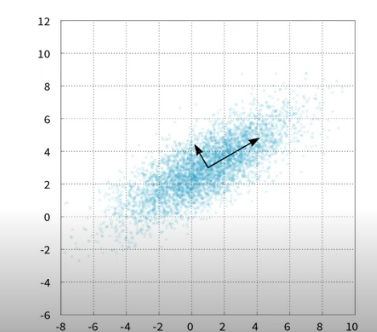

In [10]:
ldamodel = LdaModel(corpus=corpus, num_topics=5, id2word=dictionary)
ldamodel.print_topics(5,3)



/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

[(0, '0.034*"gracia" + 0.025*"presidente" + 0.025*"tiempo"'),
 (1, '0.075*"argentino" + 0.026*"economia" + 0.021*"tiempo"'),
 (2, '0.053*"presidente" + 0.035*"pandemia" + 0.027*"trabajar"'),
 (3, '0.098*"presidente" + 0.026*"gobernador" + 0.022*"compromiso"'),
 (4, '0.066*"empresa" + 0.048*"presidente" + 0.024*"dia"')]

In [11]:
lsimodel = LsiModel(corpus=corpus, num_topics=5, id2word=dictionary)

#print(lsimodel.get_topics())
lsimodel.print_topic(5)


''

###Paso 10: Medir la coherencia de los tópcios

In [12]:
cm = CoherenceModel(model=lsimodel, texts=tweetdf['text'].to_list(), dictionary=dictionary, coherence='c_v')
cm.get_coherence()

0.4739221350092901

###Paso 11: Construir nube de palabras

In [13]:
text=''
tweetdf['text'][0].sort()
for word in tweetdf['text']:
    wc=' '.join(word)
    text = text+' '+wc;

wordcloud = WordCloud().generate(text)

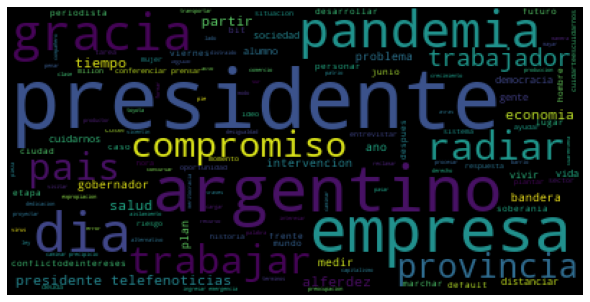

In [14]:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 


# Análisis de redes

In [15]:
user_tweets = twitter.get_user_timeline(user_id='280807268',
                                        include_rts=True, count=10, tweet_mode="extended")
follow=twitter.get_followers_list(screen_name='alferdez', count=5)['users']